# A Multi Layer Network on the Hitters Data

## Regression

In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
Hitters = pd.read_csv('data/Hitters.csv', header=0, na_values='NA').dropna()
Hitters=Hitters.reset_index(drop=True).drop(['Unnamed: 0'],axis=1)
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
y = Hitters.Salary.values  # the response variable 
X_prep = Hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1)
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1).values

In [3]:
X.shape,y.shape

((263, 19), (263,))

In [4]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3)

## sklearn NN

In [5]:
# MlP Training
mlp = MLPRegressor(hidden_layer_sizes=(50,30,20), 
                   activation='relu', 
                   learning_rate_init=0.008, 
                   learning_rate='adaptive')

In [6]:
model = mlp.fit(X_train,y_train)
print("Training set score: %f" % model.score(X_train, y_train))
print("Test set score: %f" % model.score(X_test, y_test))

Training set score: 0.883232
Test set score: 0.186252


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## pytorch

In [7]:
import copy
import numpy as np
import torch
import tqdm
import torch.nn as nn
import torch.optim as optim

In [8]:
# Define the model
model = nn.Sequential(
    nn.Linear(19, 50),
    nn.ReLU(),
    nn.Linear(50, 20),
    nn.ReLU(),
    nn.Linear(20,1),
    nn.ReLU()
)

In [9]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# train-test split of the dataset
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

MSE: 90172.88
RMSE: 300.29


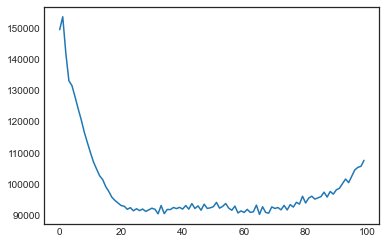

In [11]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()